# Yes I will win in just 4 days..Hardwork



In [0]:
# update tensorflow 
!pip uninstall tensorflow
!pip install tensorflow==2.1.0

Uninstalling tensorflow-1.15.0:
  Would remove:
    /tensorflow-1.15.0/python3.6/tensorflow-1.15.0.dist-info/*
    /tensorflow-1.15.0/python3.6/tensorflow/*
    /tensorflow-1.15.0/python3.6/tensorflow_core/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 3.9MB 32kB/s 
     |████████████████████████████████| 450kB 58.9MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1


In [0]:
# importation 
!pip install -q efficientnet
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from IPython.display import SVG
import efficientnet.tfkeras as efn
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

np.random.seed(0)


import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [0]:
# Load the data and define hyperparameters

In [0]:
EPOCHS = 20
SAMPLE_LEN = 100
IMAGE_PATH = "/content/drive/My Drive/Zindi problems /Third/train"
TRAIN_PATH = "/content/drive/My Drive/Zindi problems /Third/train/train_f.csv"

train_data = pd.read_csv(TRAIN_PATH)

In [0]:
train_data = train_data[['index','healthy_wheat','leaf_rust','stem_rust']]

# EDA

In [0]:
def load_image(image_id):
 
    image = cv2.imread(image_id)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

train_images = train_data["index"][:10].progress_apply(load_image)

100%|██████████| 10/10 [00:20<00:00,  2.05s/it]


In [0]:
# Visualize one leaf 
fig = px.imshow(cv2.resize(train_images[5], (512, 512)))
fig.show()


# Image processing and augmentation 

# Canny edge detection 
Canny is a popular edge detection algorithm, and as the name suggests, it detects the edges of objects present in an image. It was developed by John F. Canny in 1986. The algorithm involves several steps.

* **Noise reduction**: Since edge detection is susceptible to noise in an image, we remove the noise in the image using a 5x5 Gaussian filter.
Finding Intensity Gradient of the Image: The smoothened image is then filtered with a Sobel kernel in both horizontal and vertical directions to get the first derivative in the horizontal (Gx) and vertical (Gy) directions. From these two images, one can find the edge gradient and direction for each pixel:




* **Rounding**: The gradient is always perpendicular to edges. So, it is rounded to one of the four angles representing vertical, horizontal and two diagonal directions.

* **Non-maximum suppression**: After getting the gradient magnitude and direction, a full scan of the image is done to remove any unwanted pixels which may not constitute the edge. For this, we check every pixel for being a local maximum in its neighborhood in the direction of the gradient.

* **Hysteresis Thresholding**: This stage decides which parts are edges and which are not. For this, we need two threshold values, minVal and maxVal. Any edges with intensity gradient greater than maxVal are considered edges and those lesser than minVal are considered non-edges, and discarded. Those who lie between these two thresholds are classified edges or non-edges based on their neighborhood. If they are near “sure-edge” pixels, they are considered edges, and otherwise, they are discarded.

The result of these five steps is a two-dimensional binary map (0 or 255) indicating the location of edges on the image. Canny edge is demonstrated below with a few leaf images:

In [0]:
def edge_and_cut(img):
    emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    
    row_min = edge_coors[np.argsort([coor[0] for coor in edge_coors])[0]][0]
    row_max = edge_coors[np.argsort([coor[0] for coor in edge_coors])[-1]][0]
    col_min = edge_coors[np.argsort([coor[1] for coor in edge_coors])[0]][1]
    col_max = edge_coors[np.argsort([coor[1] for coor in edge_coors])[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    
    emb_img[row_min-10:row_min+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_max-10:row_max+10, col_min:col_max] = [255, 0, 0]
    emb_img[row_min:row_max, col_min-10:col_min+10] = [255, 0, 0]
    emb_img[row_min:row_max, col_max-10:col_max+10] = [255, 0, 0]
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(edges, cmap='gray')
    ax[1].set_title('Canny Edges', fontsize=24)
    ax[2].imshow(emb_img, cmap='gray')
    ax[2].set_title('Bounding Box', fontsize=24)
    plt.show()

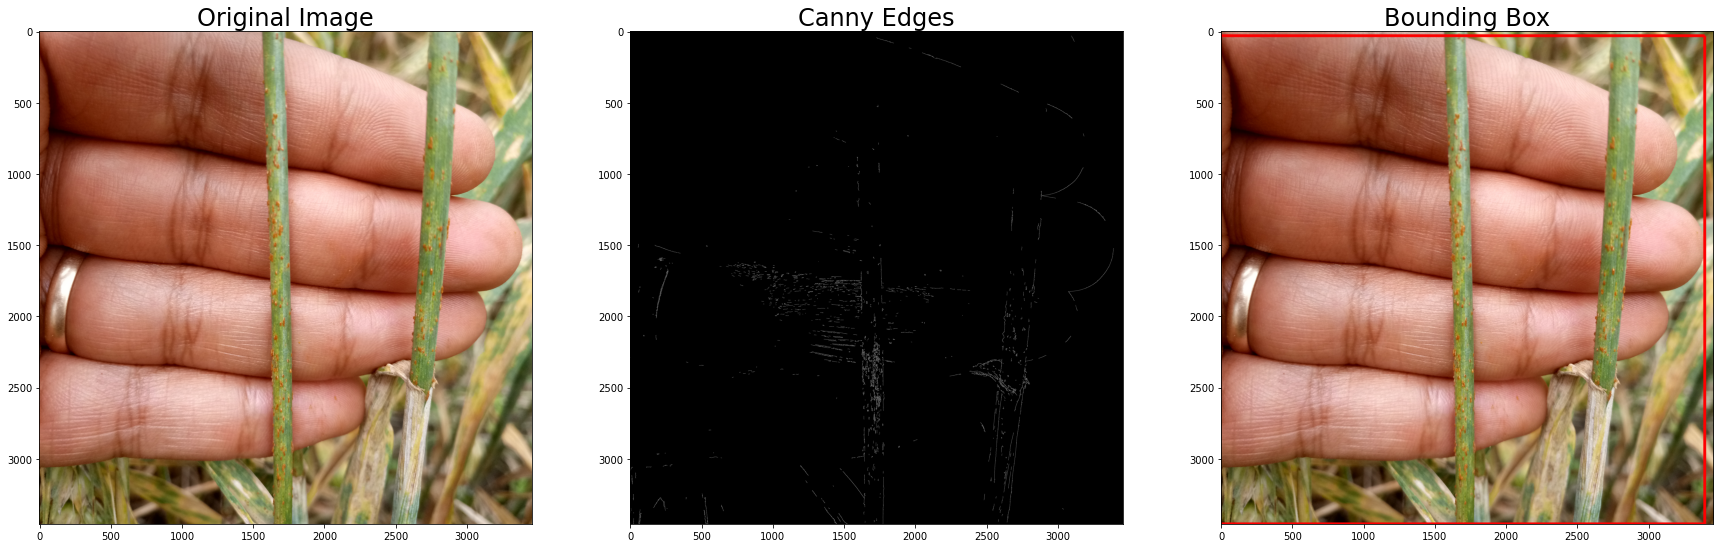

In [0]:
edge_and_cut(train_images[3])

# Flipping 

In [0]:
def invert(img):
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(30, 20))
    ax[0].imshow(img)
    ax[0].set_title('Original Image', fontsize=24)
    ax[1].imshow(cv2.flip(img, 0))
    ax[1].set_title('Vertical Flip', fontsize=24)
    ax[2].imshow(cv2.flip(img, 1))
    ax[2].set_title('Horizontal Flip', fontsize=24)
    plt.show()

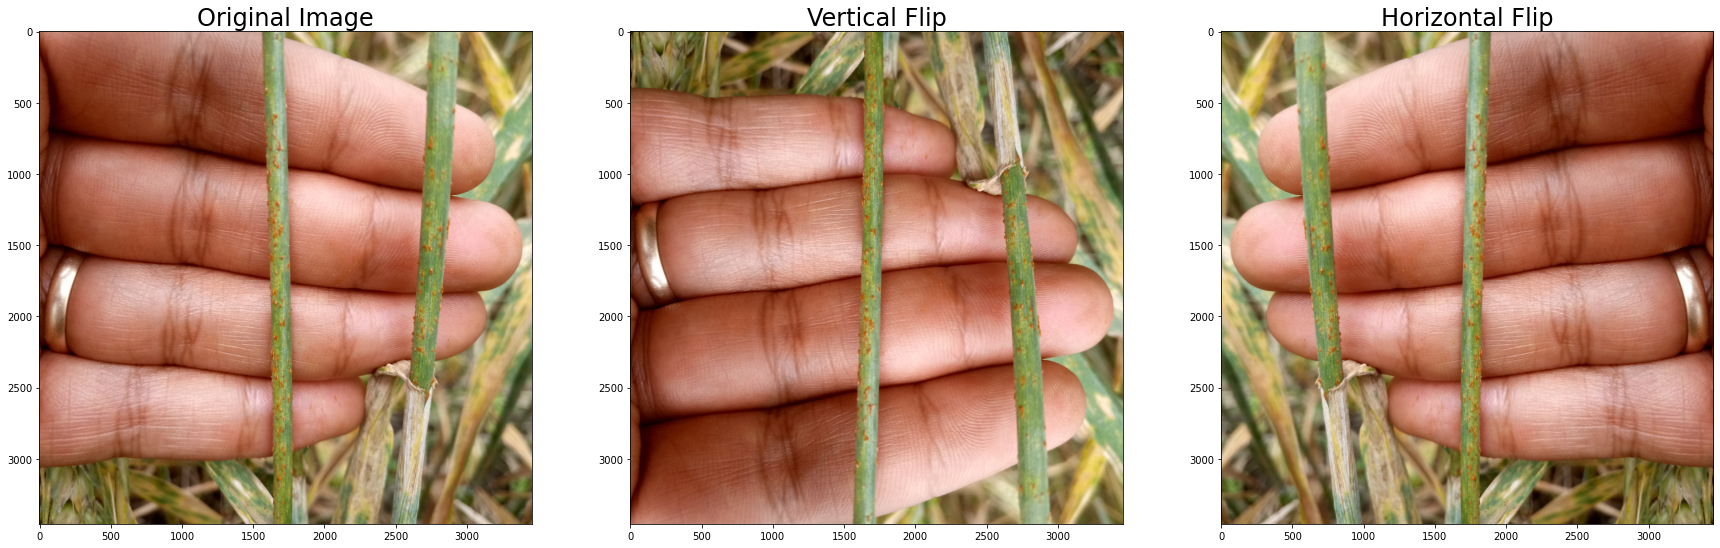

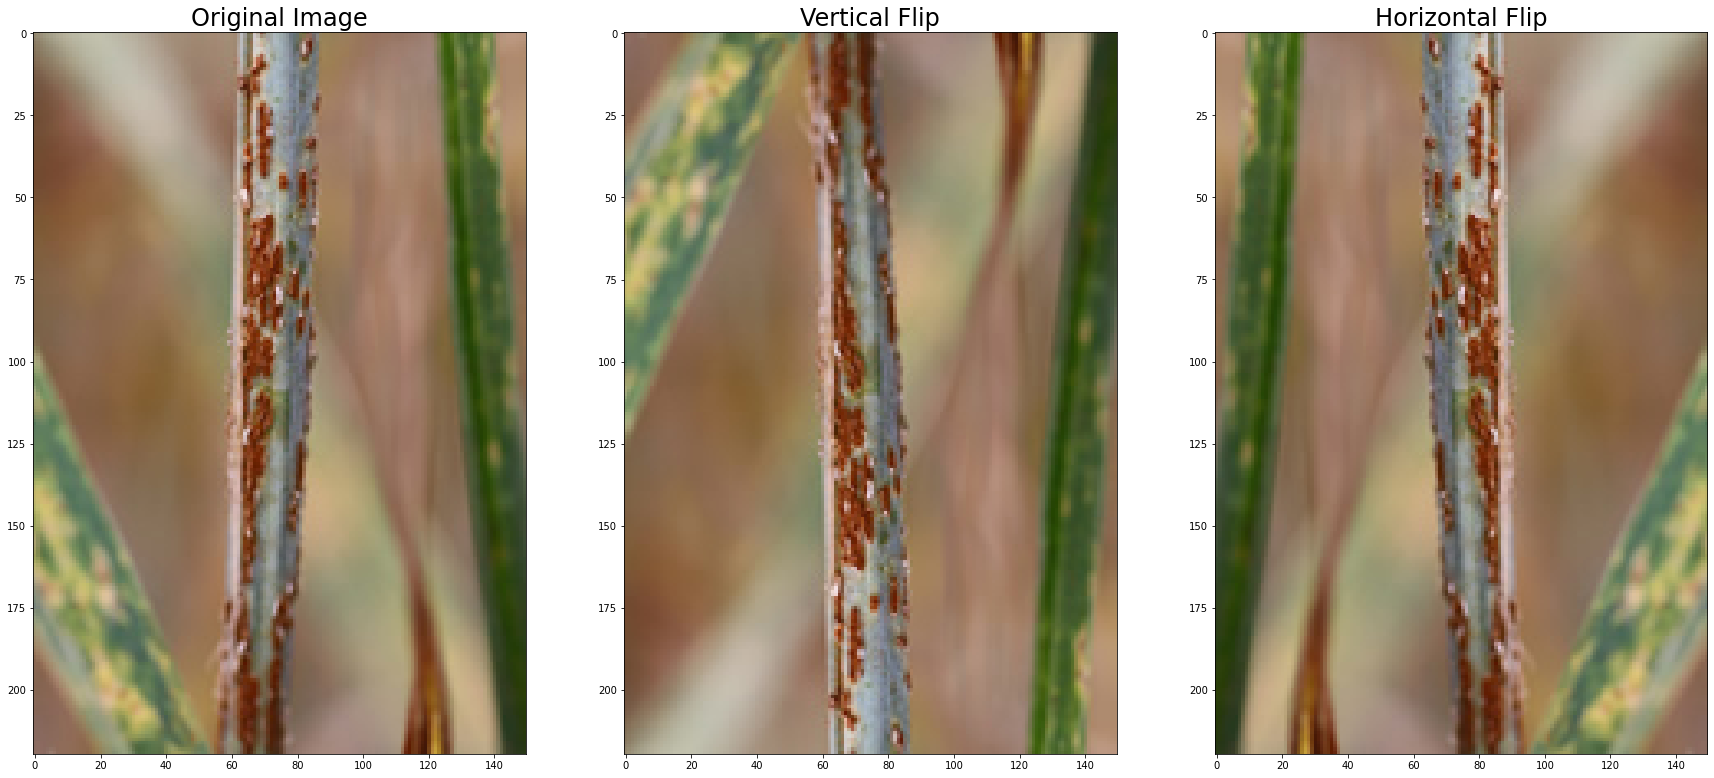

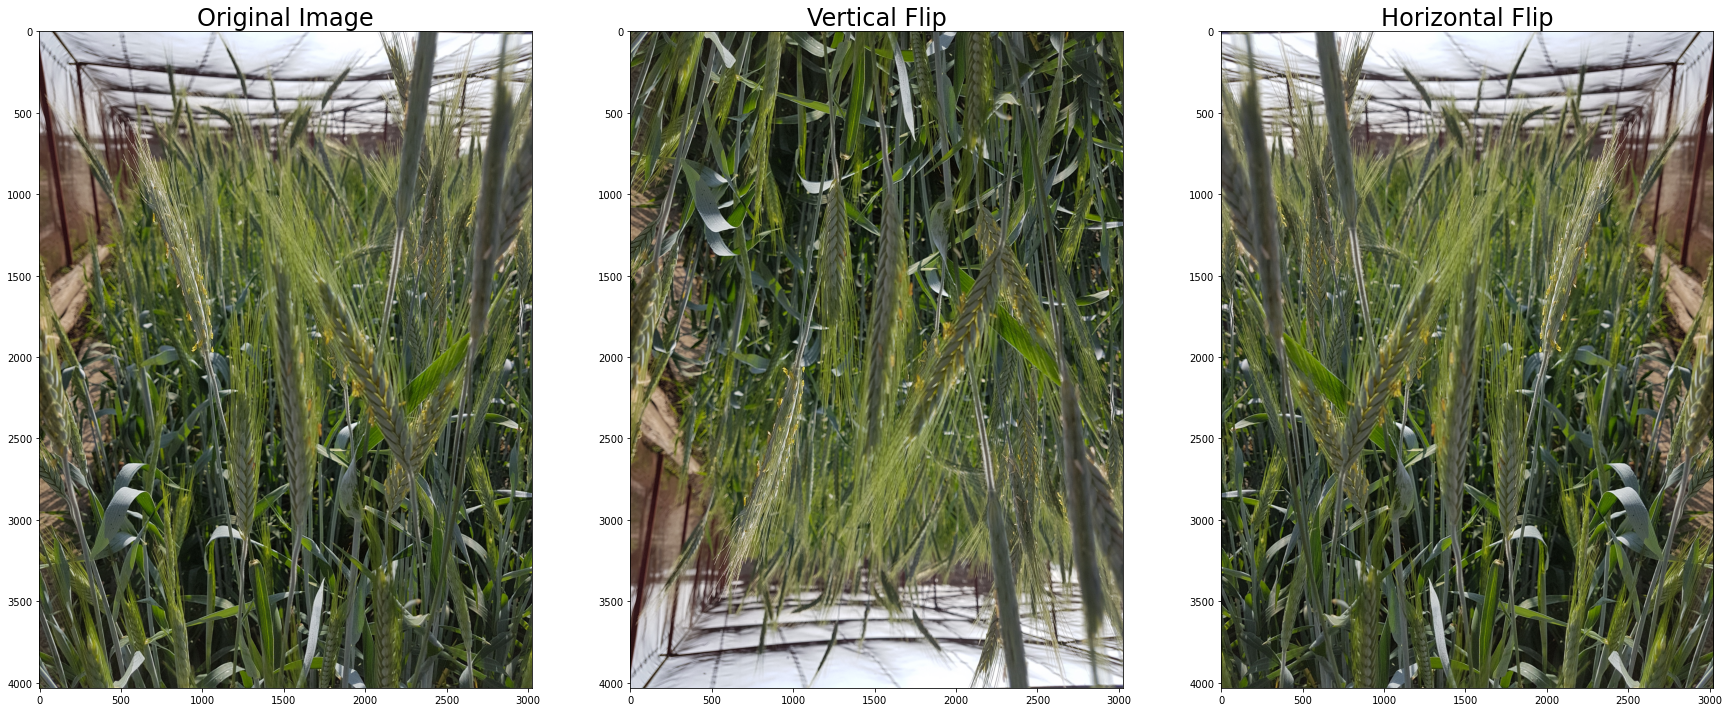

In [0]:
invert(train_images[3])
invert(train_images[4])
invert(train_images[5])


# setup TPU

In [0]:
AUTO = tf.data.experimental.AUTOTUNE
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

REPLICAS:  1


In [0]:
train_paths = train_data['index'].values
train_labels = np.float32(train_data.loc[:, 'healthy_wheat':'stem_rust'].values)

In [0]:
train_paths, valid_paths, train_labels, valid_labels =train_test_split(train_paths, train_labels, test_size=0.15, random_state=2020)

In [0]:
def decode_image(filename, label=None, image_size=(512, 512)):
    bits = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(bits, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(image, image_size)
    
    if label is None:
        return image
    else:
        return image, label

def data_augment(image, label=None, seed=2020):
    image = tf.image.random_flip_left_right(image, seed=seed)
    image = tf.image.random_flip_up_down(image, seed=seed)
           
    if label is None:
        return image
    else:
        return image, label

# Create Dataset objects

Learning rate schedule: 1e-05 to 0.0001 to 8.2e-05


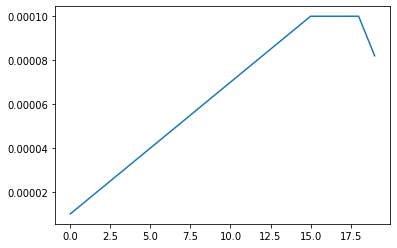

In [0]:
LR_START = 0.00001
LR_MAX = 0.0001 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 15
LR_SUSTAIN_EPOCHS = 3
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [0]:
BATCH_SIZE =16

# DenseNet Model


In [0]:
nb_classes = 3
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
img_size = 768
EPOCHS = 40

In [0]:
import numpy as np
import pandas as pd
import os
import random, re, math
import tensorflow as tf, tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers


print(tf.__version__)
print(tf.keras.__version__)

2.1.0
2.2.4-tf


In [0]:
!pip install efficientnet
import efficientnet.tfkeras as efn

In [0]:
def get_model():
    base_model =  efn.EfficientNetB7(weights='imagenet', include_top=False, pooling='avg', input_shape=(512, 512, 3))
    x = base_model.output
    predictions = Dense(nb_classes, activation="softmax")(x)
    return Model(inputs=base_model.input, outputs=predictions)

In [0]:
with strategy.scope():
    model = get_model()
    
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


In [0]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_paths, train_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .map(data_augment, num_parallel_calls=AUTO)
    .repeat()
    .shuffle(512)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
    )
valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((valid_paths, valid_labels))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)


)

In [0]:
%%time
model.fit(
    train_dataset, 
    steps_per_epoch=train_labels.shape[0] // BATCH_SIZE,
    callbacks=[lr_callback],
    epochs=EPOCHS
)

Train for 59 steps

Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
Epoch 1/40
 1/59 [..............................] - ETA: 1:22:58